In [16]:
import numpy as np  
from mp_api.client import MPRester  
import matplotlib.pyplot as plt  
from scipy import integrate  
from pymatgen.io.cif import CifWriter 
from IPython.display import FileLink, display  

key = "kHK7l7itQo2c5bLbQQIsHOTh5cQ7HUnw"  
material = "mp-20289"  

m = MPRester(key)  
prime_struct = m.get_structure_by_material_id(material)  

w = CifWriter(prime_struct)  
w.write_file(material + ".cif") 

print("Voici un lien pour télécharger la structure")  
display(FileLink(material + ".cif"))

ph_dos = m.get_phonon_dos_by_material_id(material)



Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Voici un lien pour télécharger la structure


/home/users/r/p/rperger/mp-20289.cif

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

# Courbe de la chaleur spécifique

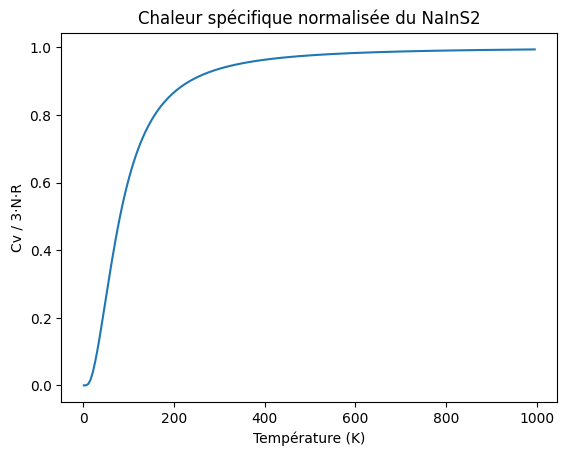

In [10]:
# On crée une liste de températures allant de 1 K à 1000 K par pas de 5 K
# On commence à 1 K pour éviter une division par zéro dans les formules

temps = np.arange(1, 1000, 5)  
R = 8.314  # Constante des gaz parfaits en J/(mol·K)

# On compte le nombre total d'atomes dans la cellule cristalline du matériau
nb_atomes = len(prime_struct)

# On calcule la chaleur spécifique réelle à partir de la densité d’états phononique
# ph_dos.cv(T) donne Cv total pour T donné, on le normalise par 3·N·R pour le comparer aux modèles
liste_cv = [ph_dos.cv(t) / (3 * nb_atomes * R) for t in temps]

# On trace la courbe de Cv réel normalisé en fonction de la température
plt.plot(temps, liste_cv)
plt.title("Chaleur spécifique normalisée du NaInS2") 
plt.xlabel("Température (K)")  
plt.ylabel("Cv / 3·N·R")  
plt.show()

# Modèle d'Eistein

Température d'Einstein optimale : 242 K


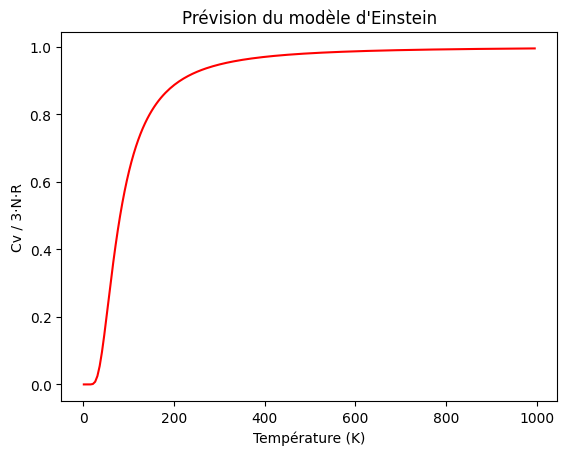

In [11]:
# Le modèle d’Einstein suppose que tous les atomes vibrent à la même fréquence (oscillateurs identiques)
# Cela permet de prédire comment la chaleur spécifique évolue avec la température

def modele_einstein(theta_e, T):
    if T == 0:
        return 0
    y = theta_e / T
    if y > 700:  # On évite les erreurs de dépassement numérique (overflow)
        return 0
    try:
        exp_y = np.exp(y)
        denom = exp_y - 1
        if denom == 0:
            return 0
        return (y**2 * exp_y) / (denom**2)  # Formule normalisée de Cv selon Einstein
    except OverflowError:
        return 0

# On cherche la température d’Einstein θ_E qui donne la meilleure correspondance avec les données réelles
meilleure_erreur_e = float('inf')
theta_e_opt = None

for theta_test in range(1, 1000):  # On teste différentes valeurs possibles de θ_E
    cumul_diff = 0
    for idx in range(1, 200):  # On calcule l’erreur quadratique entre le modèle et les données réelles
        diff = modele_einstein(theta_test, temps[idx]) - liste_cv[idx]
        cumul_diff += diff**2
    if cumul_diff < meilleure_erreur_e:
        meilleure_erreur_e = cumul_diff
        theta_e_opt = theta_test

print("Température d'Einstein optimale :", theta_e_opt, "K")

# On calcule les prédictions du modèle d’Einstein avec la meilleure température trouvée
cv_theorique_e = [modele_einstein(theta_e_opt, T) for T in temps]

# On trace la courbe prédite par le modèle d’Einstein
plt.plot(temps, cv_theorique_e, color='red')
plt.title("Prévision du modèle d'Einstein")
plt.xlabel("Température (K)")
plt.ylabel("Cv / 3·N·R")
plt.show()

# Modèle de Debye

Température de Debye optimale : 327 K


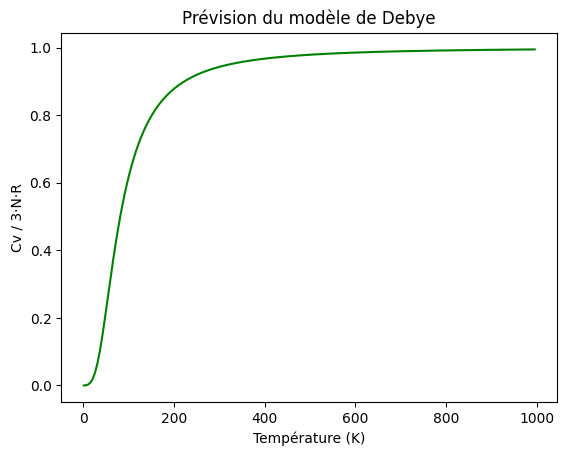

In [12]:
# Le modèle de Debye est plus réaliste : il suppose que les atomes vibrent avec un spectre de fréquences
# Il intègre les vibrations acoustiques (basses fréquences) jusqu'à une fréquence maximale (fréquence de Debye)

# Fonction intégrée dans le modèle de Debye
def integrande(x):
    try:
        exp_x = np.exp(x)
        denom = (exp_x - 1)
        if denom == 0:
            return 0
        return (x**4 * exp_x) / (denom**2)
    except OverflowError:
        return 0

# Formule de la chaleur spécifique normalisée dans le modèle de Debye
def modele_debye(theta_d, T):
    if T == 0:
        return 0
    x = theta_d / T
    if x > 700:
        x = 700
    try:
        val, _ = integrate.quad(integrande, 0, x, limit=100)
        return 3 * (T / theta_d)**3 * val
    except:
        return 0

# On cherche la température de Debye θ_D qui donne le meilleur ajustement avec les données réelles
meilleure_erreur_d = float('inf')
theta_d_opt = None

for test_d in range(1, 1000):
    ecart_total = 0
    for idx in range(1, 200):
        prediction = modele_debye(test_d, temps[idx])
        ecart_total += (prediction - liste_cv[idx])**2
    if ecart_total < meilleure_erreur_d:
        meilleure_erreur_d = ecart_total
        theta_d_opt = test_d

print("Température de Debye optimale :", theta_d_opt, "K")

# On calcule les prédictions du modèle de Debye avec la température optimale trouvée
cv_theorique_d = [modele_debye(theta_d_opt, T) for T in temps]

# On trace la courbe de chaleur spécifique prédite par le modèle de Debye
plt.plot(temps, cv_theorique_d, color="green")
plt.title("Prévision du modèle de Debye")
plt.xlabel("Température (K)")
plt.ylabel("Cv / 3·N·R")
plt.show()

# comparaison des diffèrentes courbes

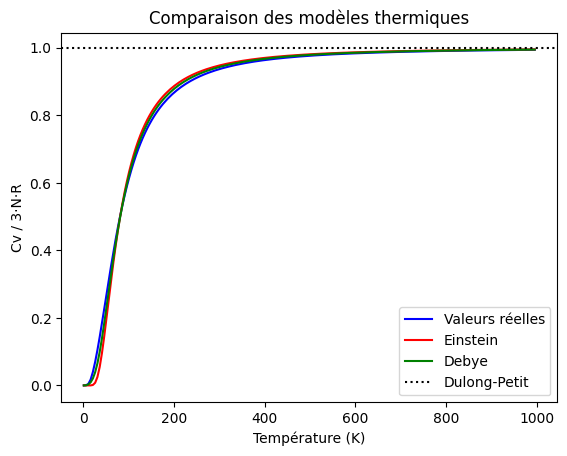

In [13]:
# On compare visuellement les courbes de Cv normalisé :
# - Les données réelles (obtenues via Materials Project)
# - Le modèle d’Einstein
# - Le modèle de Debye

plt.plot(temps, liste_cv, label="Valeurs réelles", color='blue')
plt.plot(temps, cv_theorique_e, label="Einstein", color='red')
plt.plot(temps, cv_theorique_d, label="Debye", color='green')
plt.axhline(y=1, linestyle='dotted', color='black', label="Dulong-Petit")
plt.title("Comparaison des modèles thermiques")
plt.xlabel("Température (K)")
plt.ylabel("Cv / 3·N·R")
plt.legend()
plt.show()

# comparaison des densités d'états de phonons

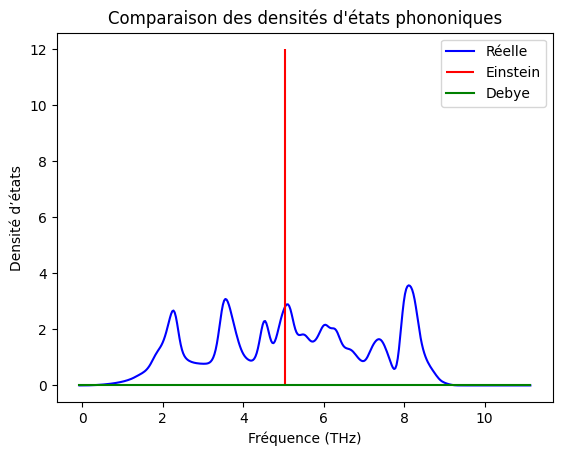

In [14]:
# On passe maintenant à la représentation des densités d'états phononiques :
# Cela montre comment les différentes fréquences de vibration sont réparties dans le matériau

k_B = 1.380649e-23  # Constante de Boltzmann en J/K
h_barre = 1.055e-34  # Constante de Planck réduite en J·s

frequences = ph_dos.frequencies  # Liste des fréquences disponibles (en THz)
densite_reelle = ph_dos.densities  # Densité d'états réelle

# Conversion de la température d’Einstein en fréquence (Einstein = pic unique)
omega_e = k_B * theta_e_opt / h_barre
f_einstein = omega_e / (2 * np.pi)

# Conversion de θ_D en fréquence maximale pour le modèle de Debye
omega_d = k_B * theta_d_opt / h_barre

# On calcule la densité d'états théorique du modèle de Debye (∝ ω²)
densite_debye = []
for f in frequences:
    omega = 2 * np.pi * f
    if omega < omega_d:
        val = (9 * nb_atomes * omega**2) / (omega_d**3)
    else:
        val = 0
    densite_debye.append(val * (2 * np.pi))  # On ajuste les unités

# On trace les trois densités d’états : réelle, Einstein (pic rouge), Debye (courbe verte)
plt.plot(frequences, densite_reelle, label="Réelle", color="blue")
plt.vlines(f_einstein * 1e-12, 0, 3 * nb_atomes, color="red", label="Einstein")
plt.plot(frequences, densite_debye, color="green", label="Debye")
plt.title("Comparaison des densités d'états phononiques")
plt.xlabel("Fréquence (THz)")
plt.ylabel("Densité d’états")
plt.legend()
plt.show()